In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import h5py as h5

import numpy as np
from scipy import stats
import scipy


#Quick fudge to make import from ../Scripts work
sys.path.append('../../Scripts')

#Custom imports
# for color map
import seaborn as sns
# for reading datafiles 
import pandas as pd

# import script that has formation channel classification functions:
from PostProcessingScripts import * 

import ClassCOMPAS     as CC ###


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
# nModels=17
# BPSnameslist = list(string.ascii_uppercase)[0:nModels]

# physicalNamesBPSmodelsWithEnter = [r'\textbf{fiducial}',\
#                            r'$\beta=0.25$', r'$\beta=0.5$',  r'$\beta=0.75$',r'\textbf{unstable}' + '\n'+ r'\textbf{case BB}',\
#                            r'$\alpha_{\rm{CE}}=0.5$',  r'$\alpha_{\rm{CE}}=2$', r'\textbf{optimistic}' +'\n' + r'\textbf{CE}',\
#                           r'\textbf{rapid SN}', r'$\rm{max} \ m_{\rm{NS}}$' +'\n' + r'$2.0\,\rm{M}_{\odot}$', r'$\rm{max} \ m_{\rm{NS}}$' +'\n' + r'$3.0\,\rm{M}_{\odot}$',\
#                           r'\textbf{no PISN}', r'\textbf{SN} '+ r'$\sigma_{\rm{rms}}^{\rm{1D}}$' +'\n' + r'$100\,\rm{km}\,\rm{s}^{-1}$',r'\textbf{SN} '+ r'$\sigma_{\rm{rms}}^{\rm{1D}}$' +'\n' + r'$30\,\rm{km}\,\rm{s}^{-1}$',\
#                           r'\textbf{SN} '+ r'$v_{\rm{k,BH}}$' +'\n' + r'$0\,\rm{km}\,\rm{s}^{-1}$' , r'$\rm{f}_{\rm{WR}} = 0.1$', r'$\rm{f}_{\rm{WR}} = 5$']

# alphabetPhysicalNameDictWithEnter =  {BPSnameslist[i]: physicalNamesBPSmodelsWithEnter[i] for i in range(len(BPSnameslist))}





def plot_kdes_single(axe=None, axe_ind=None, xparam='M1', BPSmodelNames=['A'], MSSFRmodelNames=['000'], DCOtype='BHNS', xvarrange=None, \
                               whichWeight='det', path_dir='/Volumes/Andromeda/DATA/AllDCO_bugfix/'):
    
  
    """ 
    plot total mass distribution with channels 
    input:
    
    axe = the axis to plot it on
    xvar= the array of data that you want to plot the kde of
    bw_method = bandwith method of the kernel density function you want to use (see class gaussian_kde())
    xvarrange, the x-axis range to use for the kde [should be typically slightly larger than the range of xvar]
    xlabel, ylabel = x and y labels of the plot
    xlim, ylim = xlim and ylim of the plot axis 
    """
    
    # constants
    Zsolar=0.0142
    lw = 2
    nSFRD = 28 # number of SFRD models 
    
    
    MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']
 

    DCOname_dict = {'BHNS':'BHNS', 'BBH':'BHBH', 'BNS':'NSNS'}
    DCOname = DCOname_dict[DCOtype]
#     xvarHeaders = ['Mass1', 'Mass2', 'tc',\
#                'log10(tc)', 'TotMass', 'ChirpMass', 'q', 'metallicitySystems', 'log10metallicitySystems', 'tdelay',\
#                'log10(tdelay)']
    xvar_dict = {'Mtot':4,'Mass1':0, 'Mass2':1, 'q':6, 'ChirpMass':5, 'logZ':8, 'Z':7, 'tc':2, 'log10(tc)':3, 'tdelay':9, 'log10(tdelay)':10 }


    for ind_m, BPSmodelName in enumerate(BPSmodelNames):
        color_m = colorDirDict[BPSmodelName]
        
        if axe_ind!=None:
            axe = axe[ind_m,axe_ind]
        else:
            axe=axe
        
        
        
        if ind_m==0:
            print('now at m=', BPSmodelName)

        

        

        # data for KDE / PDF:
        path_ = path_dir + alphabetDirDict[BPSmodelName] +'/'
        path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'   
        print(path)
        fdata = h5.File(path)

            

        if xparam in ['Mass1', 'Mass2', 'q', 'ChirpMass', 'Mtot','qLVK']:

            # obtain BH and NS masses
            xvar1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
            xvar2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
            M1, M2 = obtainM1BHandM2BHassymetric(m1=xvar1, m2=xvar2) # M1 will be the most massive, M2 the least massive compact object. 
            del xvar1
            del xvar2
            if xparam =='Mtot':
                xvar=M1+M2
            elif xparam=='Mass1':
                xvar = M1
            elif xparam=='Mass2':
                xvar = M2 
            elif xparam =='q':
                xvar = M1/M2
            elif xparam =='qLVK':
                xvar = M2/M1
            elif xparam=='ChirpMass':
                xvar = chirpmass(M1,M2)

            del M1
            del M2


        elif xparam=='logZ':
            ZZ = fdata['doubleCompactObjects']['Metallicity1'][...].squeeze()
            xvar = np.log10((ZZ))
            del ZZ 

        elif xparam=='Z':
            ZZ = fdata['doubleCompactObjects']['Metallicity1'][...].squeeze()
            xvar = ((ZZ))
            del ZZ


        elif xparam=='tc':
            tc = fdata['doubleCompactObjects']['tc'][...].squeeze()
            xvar = tc / 1000. # in Gyr. 
            del tc

        elif xparam=='tdelay':
            tc = fdata['doubleCompactObjects']['tc'][...].squeeze()
            tform = fdata['doubleCompactObjects']['tform'][...].squeeze()
            xvar = (tc/1000) + (tform / 1000) # in Gyr 
            del tc 
            del tform
        else:
            print('KeyError')





        ymax=0
        ii=0
        print(MSSFRmodelNames)
        for ind_mssfr, mssfr in enumerate(MSSFRmodelNames):
            print('\t now at mssfr %s'%mssfr)
            # read in MSSFR weights: 
            if whichWeight=='det':
                # get detected weights
                fparam_key = 'weights_detected'
            elif whichWeight=='z0':
                # get intrinsic weights
                fparam_key = 'weights_intrinsic'

            weightheader = 'w_' + mssfr
            w = fdata[fparam_key][weightheader][...].squeeze()

            # highlight the SFRD if they are one of the following 3
            if mssfr in ['000', '231', '312']:
                MSSFRalpha=1
                if mssfr=='000':
                    MSSFRzorder = 57
                    MSSFRlinestyle = MSSFRlinestyles[0]                    
                elif mssfr=='231':
                    MSSFRzorder=55
                    MSSFRlinestyle = MSSFRlinestyles[1]
                elif mssfr=='312':
                    MSSFRzorder=54
                    MSSFRlinestyle = MSSFRlinestyles[2]
            else:
                MSSFRalpha=0.5
                MSSFRlinestyle = '-'
                MSSFRzorder=51   






            # make the KDE, by calculating KDE values for the following x points 
            xx_boot = np.linspace(xvarrange[0],xvarrange[1],100)

#             # set bandwidth (dimensionless) based on the no of samples in the data. 
            lenXvar = len(xvar)
    
#             bw = 0.4 # TEMP
            if lenXvar<=100000:
                bw=0.1
            elif lenXvar>2*10**6:
                bw = 0.06
            elif (lenXvar<=2*10**6) & (lenXvar>10**6):
                bw = 0.06
            elif (lenXvar<=10**6) & (lenXvar>5*10**5):
                bw = 0.07 
            elif (lenXvar<=5*10**5) & (lenXvar>10**5):
                bw = 0.08
            else:
                print('error!! bw not defined')

            # for metallicity we want a seperate, larger KDE bandwidth, since here the resolution is limited by our no of Zi grid points
            if xparam=='logZ':
                bw = 0.1
            if (mssfr=='000')&(axe_ind==0):
                print('Model ', BPSmodelName, 'with %s DCOs is given a kde bandwidth of '%len(xvar),  'bw=', bw)

                
                
            KDE = MirroredKDE(xvar, lower_bound=min(xvar), upper_bound=max(xvarrange), weights=w, bw_method=bw) 
            yy_boot = KDE(xx_boot)
            del KDE 
            axe.plot(xx_boot, yy_boot, alpha=MSSFRalpha, color=color_m, zorder=MSSFRzorder, label=None,\
                     linewidth=lw+4, linestyle=MSSFRlinestyle ) 
            
            
#             print(ind_mssfr)
#             if ind_mssfr==0:
#                 print('getting at q')
#             # Plot MASS RATIOS:
#                 bw = 0.04
#                 beta = 1.1
#                 xx=np.linspace(0,1, 100000)
#                 yy = xx**(beta) # +1 for CDF 
                
#                 qKDE = MirroredKDE(yy, lower_bound=0, upper_bound=1, weights=np.ones_like(xx), bw_method=bw) 
#                 q_boot = qKDE(xx)               
                
                
#                 axe.plot(xx, q_boot,  color='gray', zorder=1, label=None,\
#                          linewidth=lw+4, linestyle=':')         


#                 beta = 1.1-1.3
#                 xx=np.linspace(0,1, 10000)
#                 yy_low = xx**(beta) # +1 for CDF 
                
#                 qKDE = MirroredKDE(yy_low, lower_bound=0, upper_bound=1, weights=np.ones_like(xx), bw_method=bw) 
#                 q_boot_low = qKDE(xx)   
                
                
#                 beta = 1.1+1.8
#                 xx=np.linspace(0,1, 10000)
#                 yy_high = xx**(beta) # +1 for CDF 
                
#                 qKDE = MirroredKDE(yy_high, lower_bound=0, upper_bound=1, weights=np.ones_like(xx), bw_method=bw) 
#                 q_boot_high = qKDE(xx)   
                                
                      
#                 axe.fill_between(x=xx, y1=q_boot_low, y2=q_boot_high,  color='b', alpha=0.2, zorder=0) 


            
            
            
            delta_x = (xx_boot[1:]-xx_boot[0:-1])[0]
            print(np.sum(yy_boot*delta_x))




            


                
        fdata.close()
#         axe.set_ylim(0.001, ylim_max)

                
    
        del xvar
        del w

        
        
        


    
    return 





In [3]:

def make_up_axis(axe=None, axe_ind=0, BPSmodelNames=['A'], xlim=[1,3.], ylim=[0.1,10], nameX='xname', nameY='yname', logY=False, logX=False):
    for ind_bps, bps_name in enumerate(BPSnameslist):
        
        axe = ax[ind_bps, axe_ind]
#         if ind_bps 

                
        if logY==True:
            axe.set_yscale('log')
        if logX==True:
            axe.set_xscale('log')
        if xlim:
            axe.set_xlim(xlim[0], xlim[1])
        if ylim:
            axe.set_ylim(ylim[0], ylim[1])
        
        if bps_name != BPSmodelNames[-1]:
            
            axe.set_xticklabels( () )
            axe.set_xticks([])

            axe.set_yticks([])
            axe.set_yticklabels( () )
            
        
        
        
        
        if  (nameX==None):

            axe.set_xticklabels( () )
            axe.set_xticks([])

        elif (nameY==None):
            axe.set_yticks([])
            axe.set_yticklabels( () )   
            
            
#         if (nameX!=None) & (nameY==None):
#             layoutAxesNoYlabel()

    return 





def make_up_axis_single_ax(axe=None,  xlim=[1,3.], ylim=[0.1,10], logY=False, logX=False):

#         if ind_bps 


    if logY==True:
        axe.set_yscale('log')
    if logX==True:
        axe.set_xscale('log')
    if xlim:
        axe.set_xlim(xlim[0], xlim[1])
    if ylim:
        axe.set_ylim(ylim[0], ylim[1])

#     if bps_name != BPSmodelNames[-1]:

#         axe.set_xticklabels( () )
#         axe.set_xticks([])

#         axe.set_yticks([])
#         axe.set_yticklabels( () )




# #     else:
#     if  (nameX==None):
#         axe.set_xticklabels( () )
#         axe.set_xticks([])

#     elif (nameY==None):
#         axe.set_yticks([])
#         axe.set_yticklabels( () )   




    return 



In [4]:

# # #Plot - overview
# xlim_low = 0.
# xlim_high = 1.



# for BPSmodelName in ['K']: #= 'G'

#     ncols, nrows= 1,1
#     fig, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(16.0,  5.5), 
#                   gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})
#     # fig, ax  = plt.figure(figsize = (16.0, 2 * 5.5))

#     lw=4

#     # add location of the COMPAS hdf5 files:
#     path_dir = '/Volumes/Andromeda/DATA/AllDCO_bugfix/'
#     TYPE,DCOtype = 'BBH', 'BBH'
#     # GLOBAL SETTINGS 
#     whichWeight='z0' # which weighting we want (intrinisic or detecter)
#     fs_t = 22
#     # FIRST COLUMN WITH CHIRP MASS ###
#     xparam, axe_ind, xlabelname ='qLVK', None,  r' $q^{-1}$' 
#     # plot percentiles:


# #     # SFRDlist = MSSFRnameslist
#     plot_kdes_single(axe=ax, axe_ind=axe_ind, xparam=xparam, BPSmodelNames=[BPSmodelName], MSSFRmodelNames=[MSSFRnameslist[0]], DCOtype=DCOtype, xvarrange=[0, 1], \
#                                       whichWeight=whichWeight, path_dir=path_dir)


#     l_ = r'$\textbf{Model %s:} %s$'%(BPSmodelName, alphabetPhysicalNameDict[BPSmodelName])
#     # 'Model %s'%(BPSmodelName)
#     ax.plot([-1,-1], [-1,-1], c=colorDirDict[BPSmodelName],  lw=5, label=l_)
#     plt.legend(fontsize=20, frameon=False, loc='upper left')
#     # ax.text(0+0.009, 1-0.009, 'model %s%s \n %s'%(BPSmodelName,mssfr,alphabetPhysicalNameDict[BPSmodelName]),\
#     #         rotation = 0, fontsize = fs+8, color = 'k', ha = 'left', va='top', transform=axe.transAxes, zorder=100)#, weight = 'bold')



#     fontsize=24
#     for tick in ax.xaxis.get_major_ticks():
#         tick.label1.set_fontsize(fontsize)
#         tick.label1.set_fontweight('bold')
#     for tick in ax.yaxis.get_major_ticks():
#         tick.label1.set_fontsize(fontsize)
#         tick.label1.set_fontweight('bold')


#     ax.set_yscale('log')
#     # plt.xscale('log')
#     ax.set_xlim(0, 1)
# #     ax.xaxis.set_major_formatter(FormatStrFormatter("%.00f"))
# #     ax.xaxis.set_minor_formatter(FormatStrFormatter("%.00f"))
#     ax.set_ylim(1e-3, 1E1 )



#     ax.grid(ls=':',color='grey')

#     ax.set_xlabel('${q}^{-1} $',fontsize=fontsize+2, labelpad=2)
#     ax.set_ylabel('$\, \mathrm{d}\mathcal{R}_{\mathrm{m}}^{0}/\mathrm{d} {q}^{-1} $ ',fontsize=fontsize+2)


    
    
    



#     plt.savefig('./qf_' + BPSmodelName + '.png', dpi = 600, bbox_inches = 'tight')







now at model F
now at m= F
/Volumes/Andromeda/DATA/AllDCO_bugfix/unstableCaseBB/COMPASCompactOutput_BBH_F.h5
['000', '111', '211', '311', '112', '212', '312', '113', '213', '313', '121', '221', '321', '122', '222', '322', '123', '223', '323', '131', '231', '331', '132', '232', '332', '133', '233', '333']
	 now at mssfr 000
0.9752003356134308
	 now at mssfr 111
0.9872681128081398
	 now at mssfr 211
0.9881141296724132
	 now at mssfr 311
0.98771627825202
	 now at mssfr 112
0.9821439757405833
	 now at mssfr 212
0.9879549135745226
	 now at mssfr 312
0.9825023093986961
	 now at mssfr 113
0.9736594108623746
	 now at mssfr 213
0.9789036917558621
	 now at mssfr 313
0.9741745830346829
	 now at mssfr 121
0.9893520050555159
	 now at mssfr 221
0.989552391060108
	 now at mssfr 321
0.9896317561915967
	 now at mssfr 122
0.9874553204637768
	 now at mssfr 222
0.9894145699426015
	 now at mssfr 322
0.9878680170691704
	 now at mssfr 123
0.9836580236580336
	 now at mssfr 223
0.9865691277575376
	 now at mssf

KeyError: "Unable to open object (file read failed: time = Fri Nov 19 21:27:22 2021\n, filename = '/Volumes/Andromeda/DATA/AllDCO_bugfix/maxNSmass3_0/COMPASCompactOutput_BBH_N.h5', file descriptor = 58, errno = 5, error message = 'Input/output error', buf = 0x7f9376cad360, total read size = 512, bytes this sub-read = 512, bytes actually read = 18446744073709551615, offset = 17967031032)"

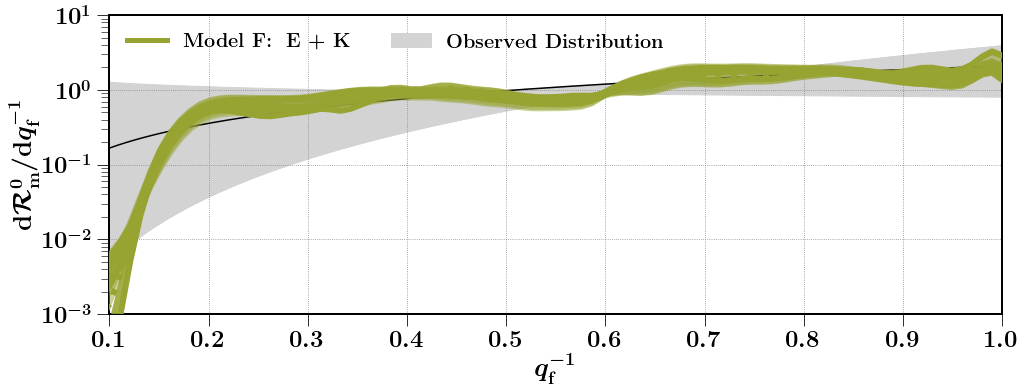

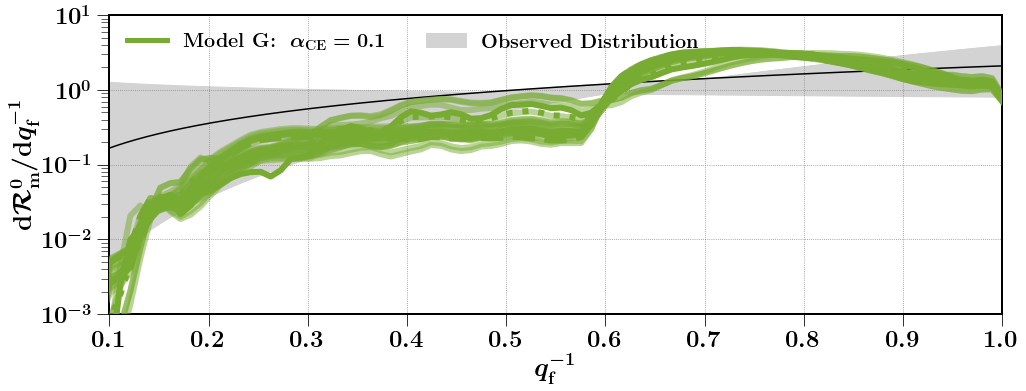

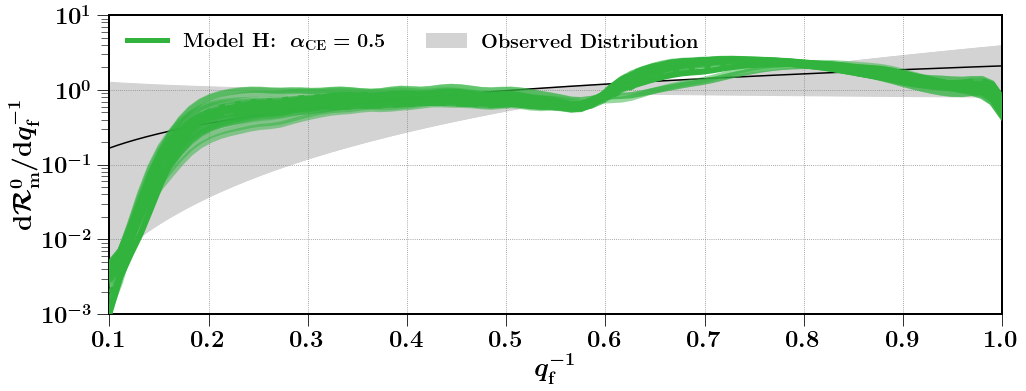

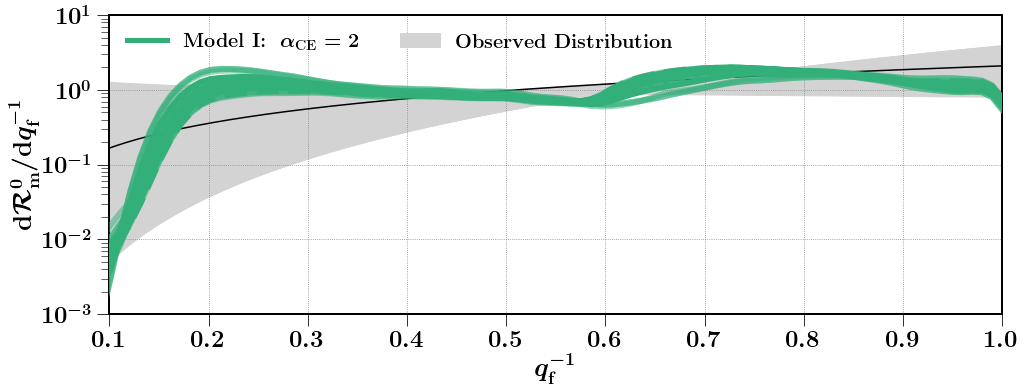

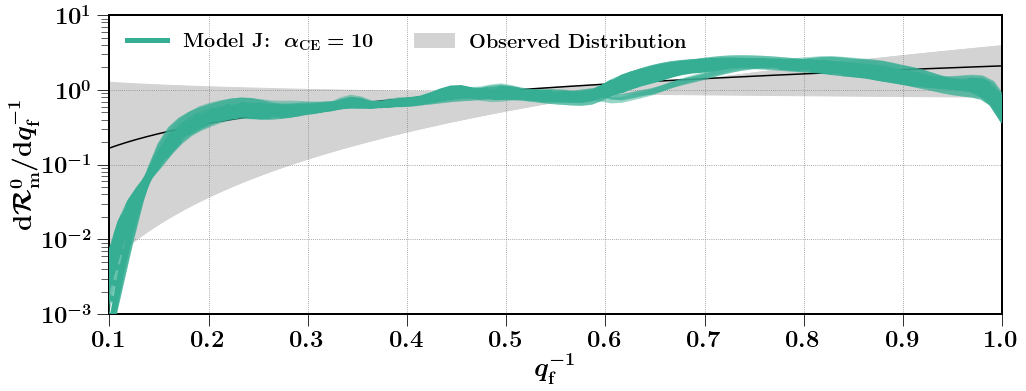

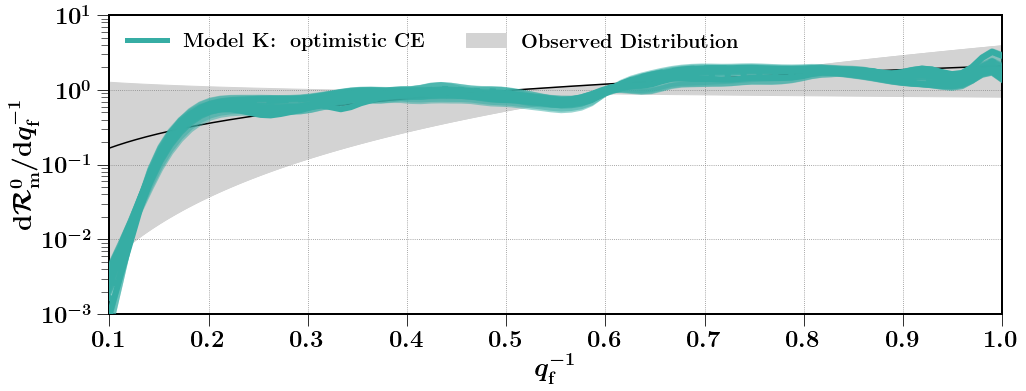

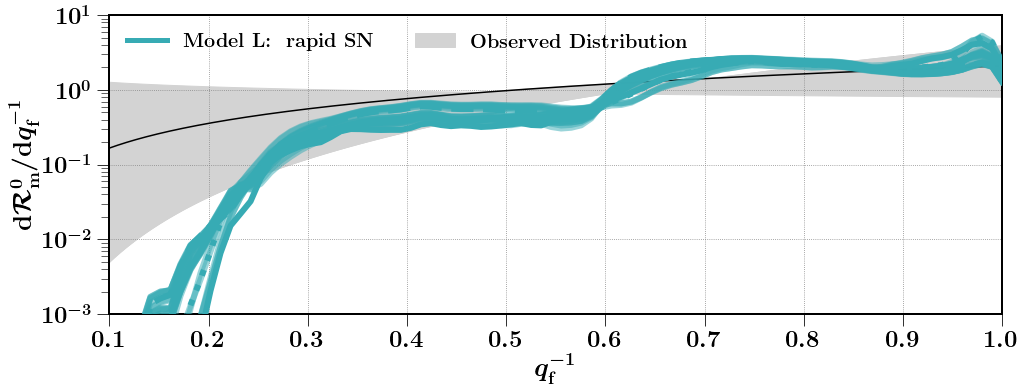

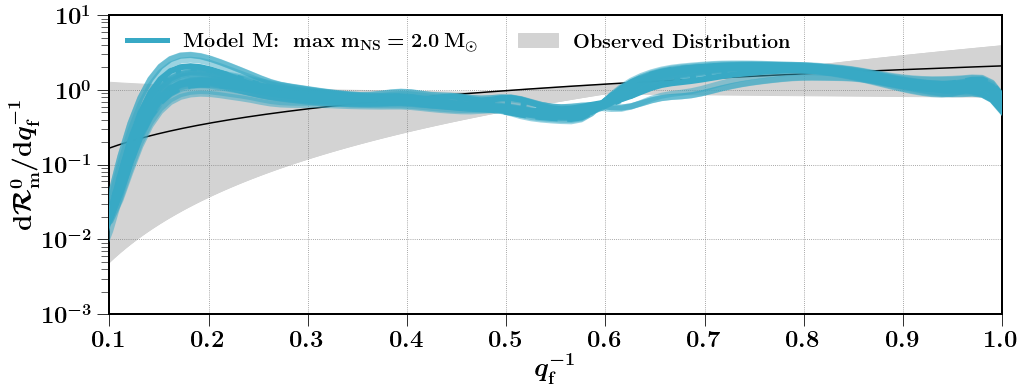

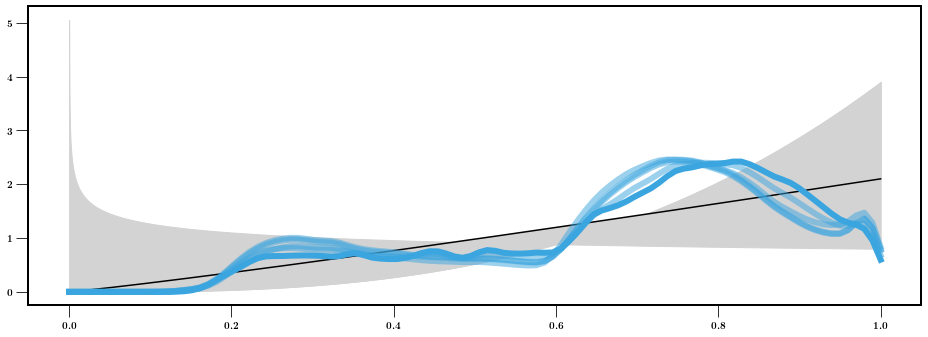

In [5]:

# #Plot - overview
xlim_low = 0.
xlim_high = 1.



for BPSmodelName in ['F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']: #= 'G'
    print('now at model %s'%BPSmodelName)
    ncols, nrows= 1,1
    fig, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(16.0,  5.5), 
                  gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})
    # fig, ax  = plt.figure(figsize = (16.0, 2 * 5.5))
    xx=np.linspace(1E-4,1, 10000)
    lw=4
    beta =1.1
    yy = xx**(beta) #* 1E2 # +1 for CDF  
    norm = np.trapz(yy,xx)
    ax.plot(xx,yy/norm, c='k')
    



    yy_low = xx**(1.1+1.8) #* 1E2 # +1 for CDF  
    norm_low = np.trapz(yy_low,xx)
#     ax.plot(xx,yy_low/norm_low, c='b')

    yy_high = xx**(1.1-1.3) #* 1E2 # +1 for CDF  
    norm_high = np.trapz(yy_high,xx)
#     ax.plot(xx, yy_high/norm_high, c='b')
    
    ax.fill_between(xx, y1=yy_high/norm_high, y2=yy_low/norm_low, color='lightgray', zorder=0 ) 
    ax.fill_between(xx, y1=yy_low/norm_low,  y2=yy/norm, color='lightgray', zorder=0, label = r'$\textbf{Observed Distribution}$' )     
#     ax.hist(x=xx, bins=len(xx), weights=yy, histtype='step', density=True, alpha=1, color='r', zorder=1, label=None,\
#              linewidth=lw, linestyle=':' , cumulative=False) 

    # add location of the COMPAS hdf5 files:
    path_dir = '/Volumes/Andromeda/DATA/AllDCO_bugfix/'
    TYPE,DCOtype = 'BBH', 'BBH'
    # GLOBAL SETTINGS 
    whichWeight='z0' # which weighting we want (intrinisic or detecter)
    fs_t = 22
    # FIRST COLUMN WITH CHIRP MASS ###
    xparam, axe_ind, xlabelname ='qLVK', None,  r' $q^{-1}$' 
    # plot percentiles:


#     # SFRDlist = MSSFRnameslist
    plot_kdes_single(axe=ax, axe_ind=axe_ind, xparam=xparam, BPSmodelNames=[BPSmodelName], MSSFRmodelNames=MSSFRnameslist, DCOtype=DCOtype, xvarrange=[0, 1], \
                                      whichWeight=whichWeight, path_dir=path_dir)


    l_ = r'$\textbf{Model %s: }$ %s'%(BPSmodelName, alphabetPhysicalNameDict[BPSmodelName])
    # 'Model %s'%(BPSmodelName)
    ax.plot([-1,-1], [-1,-1], c=colorDirDict[BPSmodelName],  lw=5, label=l_)
    plt.legend(fontsize=20, frameon=False, loc='upper left', ncol=2)
    # ax.text(0+0.009, 1-0.009, 'model %s%s \n %s'%(BPSmodelName,mssfr,alphabetPhysicalNameDict[BPSmodelName]),\
    #         rotation = 0, fontsize = fs+8, color = 'k', ha = 'left', va='top', transform=axe.transAxes, zorder=100)#, weight = 'bold')

    

    

    fontsize=24
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight('bold')
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight('bold')


    ax.set_yscale('log')
    # plt.xscale('log')
    ax.set_xlim(0.1, 1)
#     ax.xaxis.set_major_formatter(FormatStrFormatter("%.00f"))
#     ax.xaxis.set_minor_formatter(FormatStrFormatter("%.00f"))
    ax.set_ylim(1e-3, 1E1 )



    ax.grid(ls=':',color='grey')

    ax.set_xlabel('${q}_{\mathrm{f}}^{-1} $',fontsize=fontsize+2, labelpad=2)
    ax.set_ylabel('$\, \mathrm{d}\mathcal{R}_{\mathrm{m}}^{0}/\mathrm{d} {q}_{\mathrm{f}}^{-1} $ ',fontsize=fontsize+2)


    
    
    



    plt.savefig('./q_' + BPSmodelName + '.png', dpi = 600, bbox_inches = 'tight')





